# Getting started with PhenoScore
In this notebook, we will run some basic analyses using PhenoScore to demonstrate how it works.
First, lets get started and import the installed package (for instructions, please see the README.md)

In [1]:
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
from phenoscore.phenoscorer import PhenoScorer

2024-07-04 19:41:12,871 - phenopy - INFO - checking if config file exists: C:\Users\Niels Teunissen\.phenopy
2024-07-04 19:41:12,871 - phenopy - INFO - phenopy 0.5.2
2024-07-04 19:41:12,872 - phenopy - INFO - Using configuration file: C:\Users\Niels Teunissen\.phenopy\phenopy.ini


The `remove_files` function is used to remove the file for a single VUS after the HPO explanation has been generated, they are useful when using OptiLIME as this significantly reduces the runtime due to the bottleneck happening when converting the perturbed samples to PhenoScore's representation.

In [2]:
def remove_files():
    files = ['yss.npy', 'scaled_data.npy', 'data_row.npy', 'distances.npy']
    for file in files:
        if os.path.exists(file):
            os.remove(file)

Then, decided on what mode you want to run PhenoScore in: HPO-only, facial-features only, or using both. 
For now, we will do both and intialize PhenoScore with the standard options. PhenoScore will autodetect any GPUs that are available and if there are none, revert to CPU mode. If there are no GPUs detected, while there should be, please double check your installation and confirm cuDNN is installed in this environment as well.

In [3]:
mode = 'both'
N_LIME = 1 #this is purely for speed during testing purposes: for same results as in paper, set N_LIME=5

phenoscorer = PhenoScorer(gene_name='SATB1', 
                          mode=mode,
                          method_hpo_similarity='Resnik',
                          method_summ_hpo_similarities='BMA')

Using GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Now that PhenoScore is ready, let's load data. In this case, let's take a look at the SATB1 subgroup analyses: the data is included in the package.

In [4]:
X, y, img_paths, df_data = phenoscorer.load_and_process_data_from_excel(os.path.join('../', 'phenoscore', 'sample_data','satb1_data.xlsx'))
print('Data loaded!')

Data loaded!


Now that the data is loaded, we can run the permutation test, to see if we can distinguish the two groups.

In [5]:
phenoscorer.permutation_test(X, y, bootstraps=1000)
print("Brier:" + str(phenoscorer.permutation_test_brier))
print("AUC:" + str(phenoscorer.permutation_test_auc))
print("P value:" + str(phenoscorer.permutation_test_p_value))

100%|██████████| 1001/1001 [02:42<00:00,  6.16it/s]


Brier:0.18513462531105784
AUC:0.890625
P value:0.01698301698301699


The result is significant! So PhenoScore is able to detect a phenotypic difference between the two groups. Of course, we would like to know what the clinical difference is. So let's investigate this, using LIME. 

In [6]:
phenoscorer.get_lime(X, y, img_paths, n_lime=N_LIME)


Starting cross validation procedure to compare using facial/HPO data only with PhenoScore.
Finished cross validation and evaluation of model scores. Now starting LIME for the top 1 predictions to generate heatmaps and visualise phenotypic differences.


  0%|          | 0/1 [00:00<?, ?it/s]

9.031195934094221
euclidean
Calculations done for the current instance.
Max Rsquared:  0.46391559640264546


100%|██████████| 1/1 [01:30<00:00, 90.21s/it]


Figure saved as lime_figure.pdf


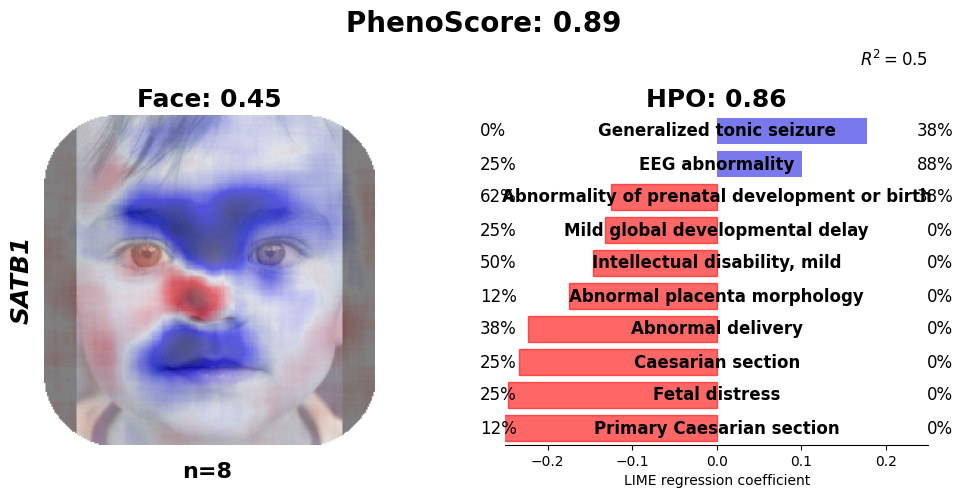

LIME images generated!


In [7]:
phenoscorer.gen_lime_and_results_figure(bg_image=os.path.join('../', 'phenoscore', 'sample_data','background_image.jpg'),
                                        df_data=df_data, filename='lime_figure.pdf')
remove_files()
print("LIME images generated!")

Finally, we can generate a VUS prediction for a SATB1 individual (as if it where an individual with a VUS, of course in this case, purely for demonstrational purposes). Because of the demonstrational purpose and speed, we choose ``lime_iter=10``(normally we would do ``lime_iter=100`` to obtain a higher resolution heatmap).

9.031195934094221
euclidean
Calculations done for the current instance.
Max Rsquared:  0.4541901278014777
Predictive score between 0 (control) and 1 (syndrome): [0.06096508]
Figure saved as individual_lime_explanations.pdf


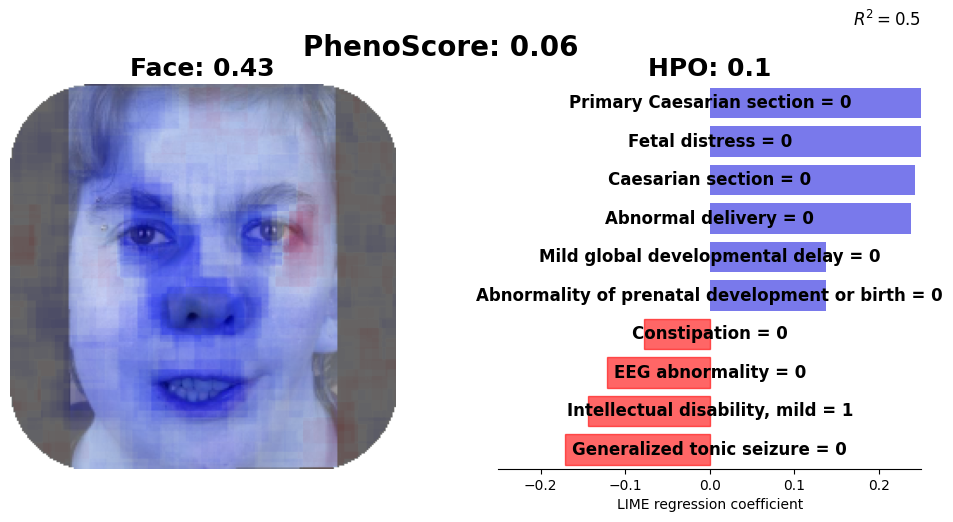

In [8]:
phenoscorer.predict_new_sample(X, y, img_paths[0], X[0,-1], lime_iter=10)
print("Predictive score between 0 (control) and 1 (syndrome): " + str(phenoscorer.vus_results['preds_both']))
phenoscorer.gen_vus_figure(filename='individual_lime_explanations.pdf')
remove_files()

We can do the same procedures for HPO-only mode as well, simply by just changing that parameter.

Using GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Data loaded!


100%|██████████| 1001/1001 [02:52<00:00,  5.80it/s]


Brier:0.18522252391902577
AUC:0.859375
P value:0.012987012987012991
Starting cross validation procedure to compare using facial/HPO data only with PhenoScore.
Finished cross validation and evaluation of model scores. Now starting LIME for the top 1 predictions to generate heatmaps and visualise phenotypic differences.


  0%|          | 0/1 [00:00<?, ?it/s]

9.031195934094221
euclidean
Calculations done for the current instance.
Max Rsquared:  0.45362472206902194


100%|██████████| 1/1 [00:09<00:00,  9.36s/it]


Figure saved as lime_figure.pdf


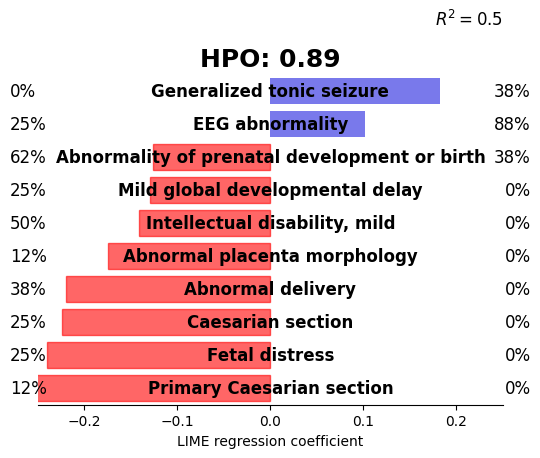

LIME images generated!


In [9]:
mode = 'hpo'
phenoscorer = PhenoScorer(gene_name='SATB1', 
                          mode=mode,
                          method_hpo_similarity='Resnik',
                          method_summ_hpo_similarities='BMA')
X, y, img_paths, df_data = phenoscorer.load_and_process_data_from_excel(os.path.join('../', 'phenoscore', 'sample_data','satb1_data.xlsx'))
print('Data loaded!')
phenoscorer.permutation_test(X, y, bootstraps=1000)
print("Brier:" + str(phenoscorer.permutation_test_brier))
print("AUC:" + str(phenoscorer.permutation_test_auc))
print("P value:" + str(phenoscorer.permutation_test_p_value))
phenoscorer.get_lime(X, y, img_paths, n_lime=N_LIME)
phenoscorer.gen_lime_and_results_figure(bg_image=os.path.join('../', 'phenoscore', 'sample_data','background_image.jpg'),
                                        df_data=df_data, filename='lime_figure.pdf')
print("LIME images generated!")
remove_files()

And similar when only using facial images (or when these are the only ones available):

Using GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Data loaded!


100%|██████████| 1001/1001 [02:41<00:00,  6.19it/s]


Brier:0.26222647474142247
AUC:0.5625
P value:0.6303696303696303
Starting cross validation procedure to compare using facial/HPO data only with PhenoScore.
Finished cross validation and evaluation of model scores. Now starting LIME for the top 1 predictions to generate heatmaps and visualise phenotypic differences.


100%|██████████| 1/1 [01:24<00:00, 84.58s/it]


Figure saved as lime_figure.pdf


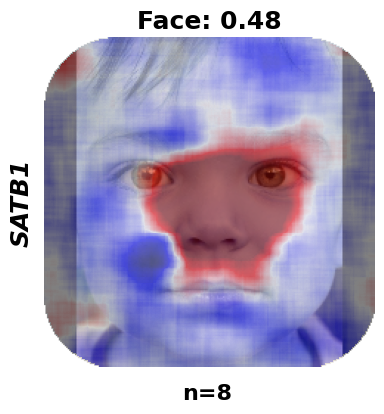

LIME images generated!


In [10]:
mode = 'face'
phenoscorer = PhenoScorer(gene_name='SATB1', 
                          mode=mode,
                          method_hpo_similarity='Resnik',
                          method_summ_hpo_similarities='BMA')
X, y, img_paths, df_data = phenoscorer.load_and_process_data_from_excel(os.path.join('../', 'phenoscore', 'sample_data','satb1_data.xlsx'))
print('Data loaded!')
phenoscorer.permutation_test(X, y, bootstraps=1000)
print("Brier:" + str(phenoscorer.permutation_test_brier))
print("AUC:" + str(phenoscorer.permutation_test_auc))
print("P value:" + str(phenoscorer.permutation_test_p_value))
phenoscorer.get_lime(X, y, img_paths, n_lime=N_LIME)
phenoscorer.gen_lime_and_results_figure(bg_image=os.path.join('../', 'phenoscore', 'sample_data','background_image.jpg'),
                                        df_data=df_data, filename='lime_figure.pdf')
print("LIME images generated!")
remove_files()